In [1]:
# automatically reload the package when it is modified
%load_ext autoreload
%autoreload 2

# Test Multiagent Simulation    

In [2]:
import jax
from jax import numpy as jnp
import numpy as np
import mediapy
from tqdm import tqdm
import dataclasses

from waymax import config as _config
from waymax import dataloader
from waymax import datatypes
from waymax import dynamics
from waymax import env as _env
from waymax import agents
from waymax import visualization
from rl_env.waymax_env import womd_loader, MultiAgentEnvironment
max_num_objects = 32
from rl_env.sim_agent_actor import SimAgentMTR

from mtr.config import cfg, cfg_from_yaml_file
cfg = cfg_from_yaml_file('tools/cfgs/waymo/rl_finetune.yaml', cfg)

from rl_env.interaction_metric import InteractionMetric
from waymax.metrics import OverlapMetric 

interaction = InteractionMetric()
overlap = OverlapMetric()


2023-11-27 20:42:10.065330: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-27 20:42:10.065360: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-27 20:42:10.065363: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/home/zixuzhang/mambaforge/envs/waymax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonote

In [3]:
# create a dataset
WOMD_1_2_0_TRAIN_LOCAL = _config.DatasetConfig(
    # path='/Data/Dataset/Waymo/V1_2_tf/validation_interactive/validation_interactive_tfexample.tfrecord@150',
    path='/Data/Dataset/Waymo/V1_2_tf/validation/validation_tfexample.tfrecord@150',
    max_num_rg_points=30000,
    data_format=_config.DataFormat.TFRECORD,
    max_num_objects=32,
)

data_iter = womd_loader(data_config=WOMD_1_2_0_TRAIN_LOCAL)


In [4]:

# Config the multi-agent environment:
init_steps = 11

# Set the dynamics model the environment is using.
# Note each actor interacting with the environment needs to provide action
# compatible with this dynamics model.
dynamics_model = dynamics.DeltaLocal()

# Expect users to control all valid object in the scene.
env = MultiAgentEnvironment(
    dynamics_model=dynamics_model,
    config=dataclasses.replace(
        _config.EnvironmentConfig(),
        init_steps = init_steps,
        max_num_objects=max_num_objects,
        controlled_object=_config.ObjectType.MODELED,
    ),
)

In [5]:
@jax.jit
def check_controlled(state: datatypes.SimulatorState):
    current_stamp = state.timestep
    is_valid = state.sim_trajectory.valid[..., current_stamp]
    is_modeled = jnp.logical_or(
        state.object_metadata.is_modeled,
        state.object_metadata.is_sdc
    )
    is_vehicle = (state.object_metadata.object_types == 1)
    
    # print(is_valid)
    # print(is_modeled)
    # print(is_vehicle)
    
    return jnp.logical_and(is_valid, jnp.logical_and(is_modeled, is_vehicle))

In [6]:
# Setup a few actors, see visualization below for how each actor behaves.

# An actor that doesn't move, controlling all objects with index > 4
obj_idx = jnp.arange(max_num_objects)
actor_gt = agents.create_expert_actor(
    dynamics_model=dynamics_model,
    is_controlled_func=lambda state: ~check_controlled(state),
)

actor_policy = SimAgentMTR(
    model_config= cfg.MODEL,
    # model_path = 'output/bc_atten_4_freeze/epoch=9-step=302840.ckpt',
    model_path= 'output/bc_atten_4_unfreeze_state/epoch=19-step=1211340.ckpt',
    # model_path= 'output/bc_atten_2_freeze_bicycle/epoch=12-step=393692.ckpt',
    # model_path = 'output/bc_atten_2_unfreeze_bicycle/epoch=10-step=333124.ckpt',
    # model_path = 'output/bc_atten_2_freeze/epoch=49-step=152600.ckpt',
    # model_path = 'output/bc_atten_0_freeze/epoch=31-step=97664.ckpt',
    # model_path = 'output/bc_atten_0_unfreeze/epoch=31-step=97664.ckpt',
    is_controlled_func = check_controlled,
)

actors = [actor_policy, actor_gt]


jit_step = jax.jit(env.step)
jit_select_action_list = [actor.select_action for actor in actors]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


==> Loading parameters from checkpoint output/bc_atten_4_unfreeze_state/epoch=19-step=1211340.ckpt to CPU
==> Checkpoint trained from version: None
The number of disk ckpt keys: 487


""

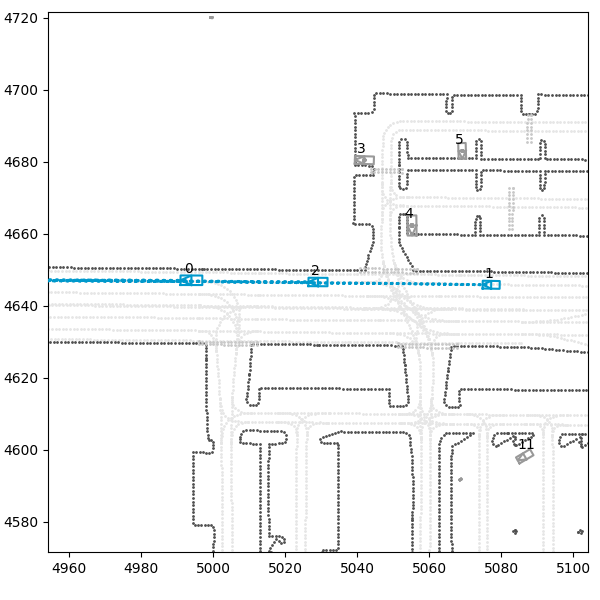

(Array([0, 1, 2], dtype=int32),)


In [79]:
scenario_id, scenario = next(data_iter)
scenario : datatypes.SimulatorState
img = visualization.plot_simulator_state(scenario, use_log_traj=True, highlight_obj = _config.ObjectType.MODELED)
mediapy.show_image(img)
print(jnp.where(scenario.object_metadata.is_modeled))


In [81]:
# get a scenario from the dataset
# scenario : datatypes.SimulatorState = next(data_iter)
states = [env.reset(scenario)]
for _ in range(states[0].remaining_timesteps):
  current_state = states[-1]

  gt_output = actor_gt.select_action({}, current_state, None, None)
  policy_output = actor_policy.select_action({}, current_state, None, None)
  action = agents.merge_actions([policy_output, gt_output])
  next_state = jit_step(current_state, action)
  
  # do a test of the interaction metric
  int_result = interaction.compute(next_state).value<0 
  overlap_result = overlap.compute(next_state).value >0

  assert (int_result == overlap_result).all()
  states.append(next_state)
  
print("Sim Agent Ids:", jnp.where(policy_output.is_controlled))

Sim Agent Ids: (Array([0, 1, 2], dtype=int32),)


In [82]:
imgs = []
for state in states:
  imgs.append(visualization.plot_simulator_state(state, use_log_traj=False, highlight_obj = _config.ObjectType.MODELED))
mediapy.show_video(imgs, fps=10)

""

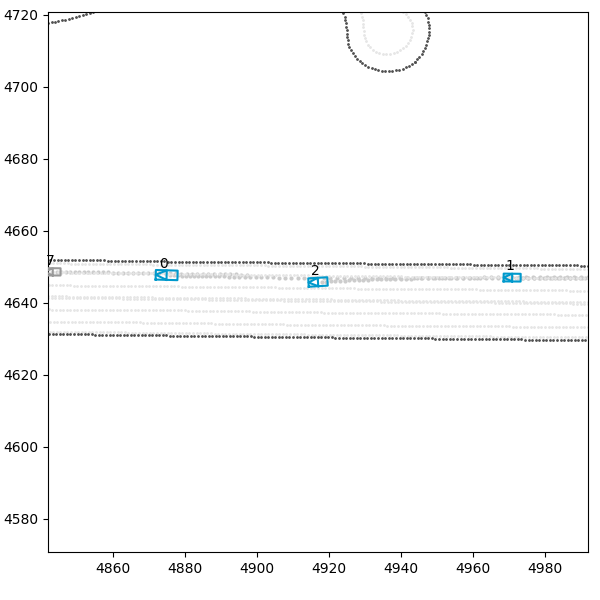

In [83]:
mediapy.show_image(visualization.plot_simulator_state(states[60], use_log_traj=False, highlight_obj = _config.ObjectType.MODELED))